In [1]:
# Load various imports 
#latest version with pitch audio too

from datetime import datetime
import pandas
from os import listdir
from os.path import isfile, join
import os

import librosa
import librosa.display
import IPython.display as ipd
from scipy.fftpack import dct

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import json
import math
import librosa


## Fitur untuk mengestrak MFCC
Ektraksi MFCC dilakukan dengan menggunakan library librosa kemudian nantinya data yang sudah di ekstrak tersebut akan di save ke dalam file JSON

In [12]:
DATASET_PATH = "../skripsi/Dataset_FIX/"
JSON_PATH = "data_15.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 3 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [4]:
data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

In [13]:
def getMFCC(audio_data, sample_rate):
  # A 1024-point STFT with frames of 64 ms and 75% overlap.
  stfts = tf.signal.stft(audio_data, frame_length=1024, frame_step=256,
                        fft_length=1024)
  spectrograms = tf.abs(stfts)

  # Warp the linear scale spectrograms into the mel-scale.
  num_spectrogram_bins = stfts.shape[-1]
  lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
  linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
    upper_edge_hertz)
  mel_spectrograms = tf.tensordot(
    spectrograms, linear_to_mel_weight_matrix, 1)
  mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
    linear_to_mel_weight_matrix.shape[-1:]))

  # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
  log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

  # Compute MFCCs from log_mel_spectrograms and take the first 13.
  mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :13]
  return mfccs

In [14]:
import json

dataset_x = []
dataset_y = []
# DATASET_PATH = "./kaggle3/AudioWAV2/"

for _class in os.listdir(DATASET_PATH):
    classPath = os.path.join(DATASET_PATH, _class)
    total_file = len(os.listdir(classPath))
    for num, file in enumerate(os.listdir(classPath)):
        filePath = os.path.join(classPath, file)
        # cari MFCC
        audio_file, sr = librosa.load(filePath)
        # decoded_wav = tf.audio.decode_wav(audio_file)
        mfcc = getMFCC(audio_file, sr)
        dataset_x.append(mfcc)
        dataset_y.append(_class)

        print(f"processed {num}/{total_file}")

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

print("Shape of dataset_x (MFCC) : ", dataset_x.shape)
print("Shape of dataset_y (Class) : ", dataset_y.shape)

#---------------SIMPAN JSON---------------

# Save dataset_x and dataset_y to JSON file
# output_json_path = "./kaggle3/dataset2.json"

# Convert NumPy arrays to lists before serialization
dataset_x_list = [item.tolist() for item in dataset_x]
dataset_y_list = dataset_y.tolist()

# Create a dictionary with keys "data" and "labels"
data_dict = {"mfcc": dataset_x_list, "labels": dataset_y_list}

# Serialize the dictionary to a JSON-formatted string
json_data = json.dumps(data_dict, indent=2)

# Write the JSON string to the output file
with open(JSON_PATH, "w") as json_file:
    json_file.write(json_data)

print(f"Data saved to {JSON_PATH}")

processed 0/850
processed 1/850
processed 2/850
processed 3/850
processed 4/850
processed 5/850
processed 6/850
processed 7/850
processed 8/850
processed 9/850
processed 10/850
processed 11/850
processed 12/850
processed 13/850
processed 14/850
processed 15/850
processed 16/850
processed 17/850
processed 18/850
processed 19/850
processed 20/850
processed 21/850
processed 22/850
processed 23/850
processed 24/850
processed 25/850
processed 26/850
processed 27/850
processed 28/850
processed 29/850
processed 30/850
processed 31/850
processed 32/850
processed 33/850
processed 34/850
processed 35/850
processed 36/850
processed 37/850
processed 38/850
processed 39/850
processed 40/850
processed 41/850
processed 42/850
processed 43/850
processed 44/850
processed 45/850
processed 46/850
processed 47/850
processed 48/850
processed 49/850
processed 50/850
processed 51/850
processed 52/850
processed 53/850
processed 54/850
processed 55/850
processed 56/850
processed 57/850
processed 58/850
process

### Melakukan load data supaya bisa dimasukkan ke model

In [15]:
DATA_PATH = "../skripsi/data_15.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

## Training and Testing

In [16]:
X, y = load_data(DATA_PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

Data succesfully loaded!


#### Memberikan label encoder ke dalam label karena label berisikan data string

In [17]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [18]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [19]:
print('This is y_train:\n',y_train)
print('This is ye_test:\n',y_test)

This is y_train:
 [0 2 3 ... 2 3 1]
This is ye_test:
 [3 1 1 1 2 2 2 0 1 3 2 3 0 3 0 2 3 0 2 3 3 2 3 0 2 1 2 1 1 0 1 1 1 0 3 3 1
 2 3 2 0 3 0 3 0 1 2 0 3 2 2 1 3 3 3 3 3 0 3 0 0 2 0 2 2 2 1 0 1 3 1 2 2 3
 3 3 3 1 3 0 3 3 0 0 1 3 1 0 0 2 0 1 0 3 2 1 3 2 3 0 1 1 0 2 1 1 2 0 3 2 0
 1 1 1 2 1 3 2 1 1 0 3 0 0 2 0 3 0 3 2 2 2 3 3 2 0 3 2 3 3 1 2 3 3 3 2 1 3
 1 1 3 0 1 2 0 0 3 0 2 2 3 0 0 2 1 1 2 2 1 2 1 3 1 1 0 1 0 1 0 1 3 3 0 0 3
 0 1 1 0 0 2 0 2 1 1 1 3 2 2 1 2 0 1 0 2 1 2 3 3 1 3 1 2 0 1 2 2 1 2 0 3 1
 2 0 0 1 3 1 0 1 0 3 0 3 3 1 0 0 3 3 3 2 3 2 1 1 1 0 2 1 1 0 3 0 2 2 0 0 2
 0 2 1 2 2 0 1 1 2 0 3 1 3 2 1 2 2 0 0 3 1 0 1 3 1 2 3 2 2 1 2 2 3 1 2 2 0
 1 1 0 0 0 1 1 0 1 2 2 2 2 2 1 0 2 2 0 0 3 3 3 0 3 2 2 3 0 3 2 1 2 2 1 0 2
 0 3 2 1 0 0 2 1 1 2 3 3 0 1 3 0 2 1 0 0 1 2 1 1 3 0 2 3 0 2 1 0 3 0 0 0 0
 2 3 2 2 1 1 1 2 3 2 1 2 3 2 1 2 0 1 0 1 3 0 2 2 0 0 1 2 0 1 3 1 3 1 1 3 2
 1 2 2 1 1 3 1 0 3 3 2 0 2 0 3 3 1 0 0 1 3 1 2 0 0 0 2 0 2 3 3 1 1 3 0 3 2
 3 0 3 2 2 3 0 0 3 2 3 3 0 3 3 2 2 1 0 1 1 1 1

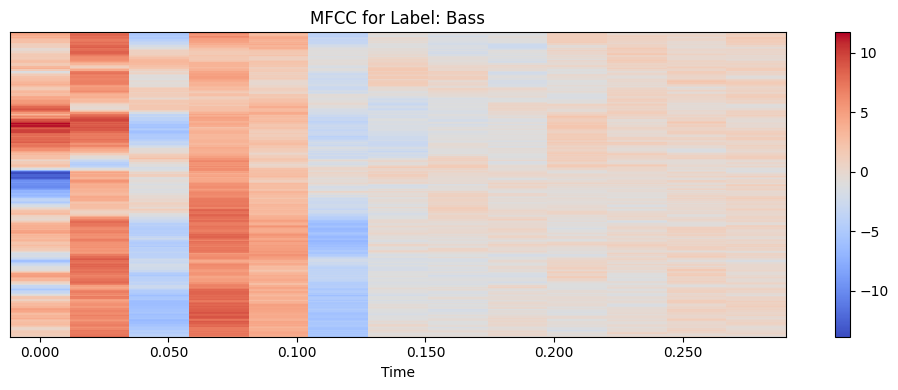

In [20]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[1200], x_axis='time')
plt.colorbar()
plt.title('MFCC for Label: {}'.format(y[1200]))
plt.tight_layout()
plt.show()

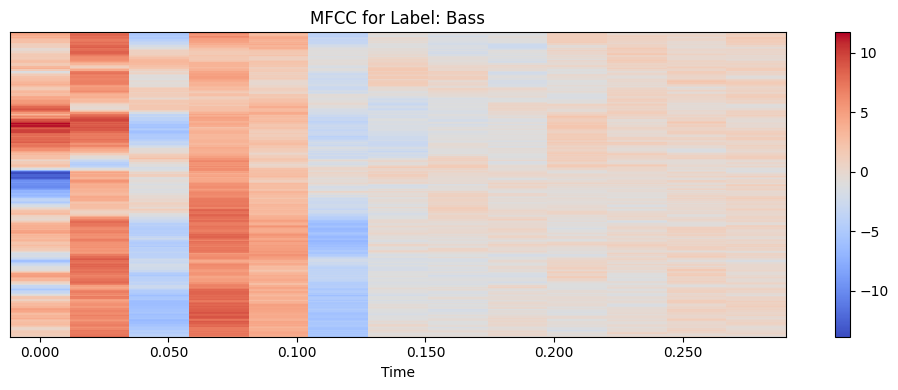

In [22]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[1200], x_axis='time')
plt.colorbar()
plt.title('MFCC for Label: {}'.format(y[1200]))
plt.tight_layout()
plt.show()

Melakukan reshape pada data train karena untuk melakukan training diperlukan sebuah input shape berupa vector 3D untuk memasukkan kedalam Conv2D layers

In [23]:
print(X_train.shape)
print(X_test.shape)

(2720, 255, 13)
(680, 255, 13)


In [24]:
X_train = X_train.reshape(-1, 255, 13, 1)
X_test = X_test.reshape(-1, 255, 13, 1)

In [25]:
print(X_train.shape)
print(X_test.shape)

(2720, 255, 13, 1)
(680, 255, 13, 1)


In [26]:
print(y_train.shape)
print(y_test.shape)

(2720,)
(680,)


In [27]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# CNN Architecture
### Penyusunan arsitektur yang digunakan
Arsitektur yang digunakan merupakan arsitektur CNN paling umum yang ada dengan menggunakan Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout dan Dense Layer untuk output layers

Membuat labels menjadi bersifat categorical

In [28]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4, dtype='float32')

## CNN 2D

In [29]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3),
                     padding='same',
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate),
                     padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(4, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 13, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 255, 13, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 255, 13, 32)      128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 255, 13, 32)      0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 11, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 253, 11, 32)       0

In [31]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
num_epochs = 250
num_batch_size = 128

model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 13, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 255, 13, 32)       0         
                                                                 
 batch_normalization (BatchN  (None, 255, 13, 32)      128       
 ormalization)                                                   
                                                                 
 spatial_dropout2d (SpatialD  (None, 255, 13, 32)      0         
 ropout2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 11, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 253, 11, 32)       0

c:\Users\Attar\anaconda3\envs\tfgpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=callbacks)

Epoch 1/250
85/85 [==============================] - 6s 19ms/step - loss: 0.9566 - accuracy: 0.6327 - val_loss: 1.0878 - val_accuracy: 0.5647
Epoch 2/250
85/85 [==============================] - 1s 14ms/step - loss: 0.7422 - accuracy: 0.7437 - val_loss: 0.8044 - val_accuracy: 0.7662
Epoch 3/250
85/85 [==============================] - 1s 15ms/step - loss: 0.6607 - accuracy: 0.7846 - val_loss: 0.6359 - val_accuracy: 0.8176
Epoch 4/250
85/85 [==============================] - 1s 15ms/step - loss: 0.6105 - accuracy: 0.8007 - val_loss: 0.5519 - val_accuracy: 0.8397
Epoch 5/250
85/85 [==============================] - 1s 14ms/step - loss: 0.5806 - accuracy: 0.8085 - val_loss: 0.4991 - val_accuracy: 0.8588
Epoch 6/250
85/85 [==============================] - 1s 14ms/step - loss: 0.5495 - accuracy: 0.8320 - val_loss: 0.4581 - val_accuracy: 0.8765
Epoch 7/250
85/85 [==============================] - 1s 14ms/step - loss: 0.5107 - accuracy: 0.8415 - val_loss: 0.4379 - val_accuracy: 0.8853
Epoch 

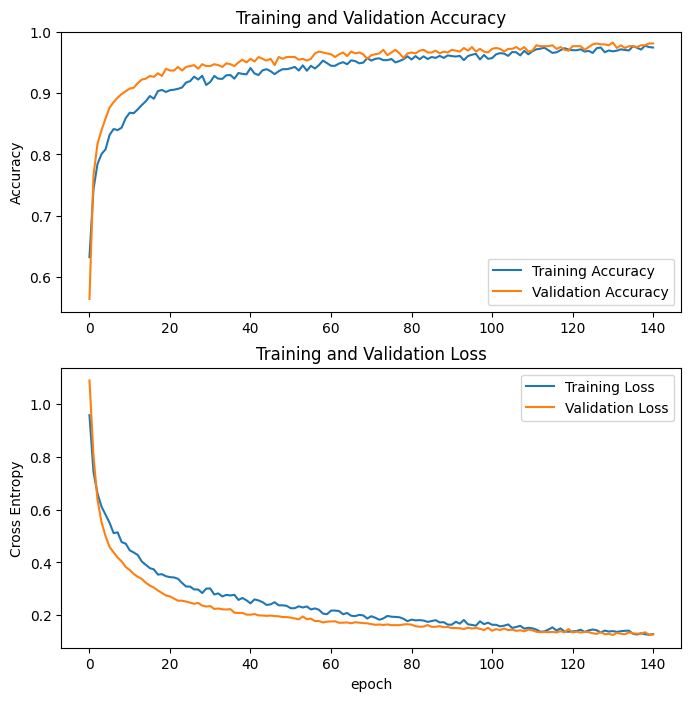

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
# Evaluating the model on the training and testing set
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9963235259056091
Testing Accuracy:  0.9808823466300964


In [35]:
preds = model.predict(X_test)
classpreds = np.argmax(preds, axis=1)
y_testclass = np.argmax(y_test, axis=1)

22/22 [==============================] - 0s 8ms/step


In [36]:
f1 = f1_score(y_testclass, classpreds, average='weighted')
print("F1 score:", f1)

F1 score: 0.9809239495412572


In [37]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_testclass, classpreds)

In [38]:
cm_display =  metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix)

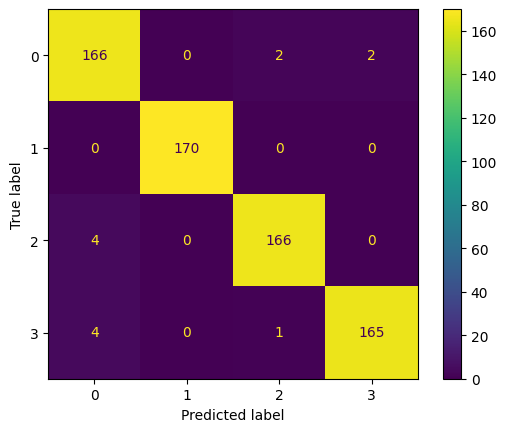

In [39]:
cm_display.plot()

In [40]:
model.save('VocalClassifier10.h5')

In [41]:
c_names = ['Alto', 'Bass', 'Sopran', 'Tenor']

In [42]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

        Alto       0.95      0.98      0.97       170
        Bass       1.00      1.00      1.00       170
      Sopran       0.98      0.98      0.98       170
       Tenor       0.99      0.97      0.98       170

    accuracy                           0.98       680
   macro avg       0.98      0.98      0.98       680
weighted avg       0.98      0.98      0.98       680



In [46]:
y_prob = model.predict(X_train, batch_size=32) 
y_classes = y_prob.argmax(axis=-1)
# pred_labels = np.class_names[y_classes]
print(y_classes)


85/85 [==============================] - 1s 8ms/step
[3 2 1 ... 3 1 2]


In [49]:
model = load_model('../skripsi/VocalClassifier10.h5')

In [50]:
y, sr = librosa.load('../skripsi/Dataset_FIX/Tenor/Tenor_158.wav')
        # decoded_wav = tf.audio.decode_wav(audio_file)
mfccs_val = getMFCC(y, sr)

In [51]:
X_val = np.array(mfccs_val)
print(X_val.shape)

(255, 13)


In [52]:
X_val = X_val.reshape(1, 255, 13, 1)

In [53]:
y_prob = model.predict(X_val) 
y_classes = y_prob.argmax(axis=1)
# pred_labels = np.class_names[y_classes]
print(y_classes)

1/1 [==============================] - 0s 130ms/step
[3]
